<a href="https://colab.research.google.com/github/saiashirwad/relation-prediction-3/blob/master/Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if "relation-prediction-3" not in os.listdir("/content"):
    !git clone https://github.com/saiashirwad/relation-prediction-3
%cd /content/relation-prediction-3
!git pull

/content/relation-prediction-3
Already up to date.


In [29]:
!nvidia-smi

Mon May  4 08:05:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    36W / 250W |  12399MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!./colab.sh

In [0]:
from torchkge.data.DataLoader import load_fb15k237

In [0]:
from importlib import reload 
import train
import utils 
import layers
import evaluation
reload(utils)
reload(evaluation)
reload (layers)
reload(train)
from evaluation import *

In [0]:
kg_train, kg_test, kg_val = load_fb15k237()

In [0]:
model = None

In [33]:
model = train.train(kg_train, 100, 100, 10, 10000, "cuda", n_epochs=100, n_heads=5, model=model)

epoch: 0, loss: 3.2811475140707835
epoch: 1, loss: 3.274234243801662
epoch: 2, loss: 3.2677190814699446
epoch: 3, loss: 3.2630103656223843
epoch: 4, loss: 3.2569844126701355
epoch: 5, loss: 3.25292021887643
epoch: 6, loss: 3.2468012741633823
epoch: 7, loss: 3.2414286647524153
epoch: 8, loss: 3.237714265074049
epoch: 9, loss: 3.232444473675319
epoch: 10, loss: 3.226143538951874
epoch: 11, loss: 3.222060935837882
epoch: 12, loss: 3.2132164921079363
epoch: 13, loss: 3.2101731300354004
epoch: 14, loss: 3.2064862166132246
epoch: 15, loss: 3.2029910002435957
epoch: 16, loss: 3.196321725845337
epoch: 17, loss: 3.1928546173231944
epoch: 18, loss: 3.1857304658208574
epoch: 19, loss: 3.1833710755620683
epoch: 20, loss: 3.1762703146253313
epoch: 21, loss: 3.172108156340463
epoch: 22, loss: 3.1652085525648936
epoch: 23, loss: 3.160451556955065
epoch: 24, loss: 3.1565007397106717
epoch: 25, loss: 3.1509640216827393
epoch: 26, loss: 3.1442932401384627
epoch: 27, loss: 3.143266098839896
epoch: 28, lo

In [34]:
evaluation.eval(kg_val, model, 100, 100)

mean rank: 5721.15
hits@10: 0.06999999999999999


In [35]:
n_samples = 1000
dataloader = DataLoader(kg_val, 1, shuffle=True)                                                                                  
data = [d for d in dataloader]                                                                                                    
                                                                                                                                
n = n_samples                                                                                                                     
                                                                                                                                
n_ent = kg_val.n_ent                                                                                                              
model.eval()                                                                                                                      
                                                                                                                                
head_rank_mean, tail_rank_mean = [0] * 2                                                                                          
head_hits_10, tail_hits_10 = [0] * 2                                                                                              

ranks = []
                                                                                                                                
with torch.no_grad():                                                                                                             
    for i in range(n_samples):                                                                                                    
        triplets_h = generate_eval_triplets(data[i], "head", n_ent)                                                               
        triplets_h, _ = negative_sampling(triplets_h, n_ent, 0)                                                                   
        triplets_h = triplets_h.to("cuda")                                                                                        
        ee, re = model(triplets_h)                                                                                                
                                                                                                                                
        dst = ee[data[i][1]].squeeze()                                                                                            
        rel = re[data[i][2]].squeeze()                                                                                            
        dist = ee + (rel - dst).repeat(n_ent).view(-1, 100)                                                                       
        head_preds = torch.topk(torch.norm(dist, dim=1), k=n_ent).indices.cpu().tolist()                                          
        rank = head_preds.index(data[i][0])                                                                                       
        head_rank_mean += rank                                                                                                    
        if rank < 10:                                                                                                             
            head_hits_10 += 1                                                                                                     
                                                                                                                                
        # # # # tail                                                                                                              
        triplets_t = generate_eval_triplets(data[i], "tail", n_ent)                                                               
        triplets_t, _ = negative_sampling(triplets_t, n_ent, 0)                                                                   
        triplets_t = triplets_t.to("cuda")                                                                                        
        ee, re = model(triplets_t)                                                                                                
                                                                                                                                
        src = ee[data[i][0]].squeeze()                                                                                            
        rel = re[data[i][2]].squeeze()                                                                                            
        dist = (src + rel).repeat(n_ent).view(-1, 100) - ee                                                                       
        tail_preds = torch.topk(torch.norm(dist, dim=1), k=n_ent).indices.cpu().tolist()                                          
        rank = tail_preds.index(data[i][1])                                                                                       
        tail_rank_mean += rank                                                                                                    
        if rank < 1000:                                                                                                             
            tail_hits_10 += 1                                                                                                     
        
        ranks.append(rank)
                                                                                                                                
    # head_rank_mean /= n                                                                                                           
    tail_rank_mean /= n                                                                                                           
    # head_hits_10 /= n                                                                                                             
    tail_hits_10                                                                                                            
    # mean_rank = (head_rank_mean + tail_rank_mean) / 2                                                                             
    # hits_10 = (head_hits_10 + tail_hits_10) / 2                                                                                   
                                                                                                                                
#  print(f"Mean Rank: {mean_rank}")                                                                                               
#  print(f"Hits@10: {hits0}")                                                                                                     
# print("mean rank: {}".format(mean_rank))                                                                                          
# print("hits@10: {}".format(hits_10))  
print(tail_rank_mean)
print(tail_hits_10)

4370.015
359


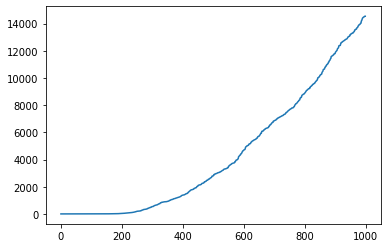

In [36]:
plt.plot(np.arange(1000), sorted(ranks))

In [0]:
import numpy as np